# TP N° 1
## Laptop Price Prediction
El dataset que elegimos se compone de un conjunto de datos de laptops y algunas de sus especificaciones.
Segun el autor, los datos fueron Scrapeados de sitios de e-commerce, utilizando herramientas basicas de scraping web, como Beautiful Soup.


# 1 - Listado de variables y selección

## Entrada
* Manufacturer: Marca / fabricante del equipo
* Category: Tipo de notebook
* Screen Size: Tamaño diagonal de la pantalla en pulgadas
* Screen Type: Resolución y tipo de panel
* CPU: Modelo de procesador
* RAM: Capacidad de memoria
* Storage: Tipo y tamaño de almacenamiento interno
* GPU: Tipo y modelo de procesador de gráficos
* OS: Sistema operativo
* Weight: Peso

## Salida
* Price: Será reducida con rangos a valores "bajo", "medio" o "alto"

## No utilizadas
* Model Name: Texto arbitrario que generalmente no representa las capacidades del producto, y cuando lo hace meramente tiene agregados valores de otras columnas
* OS Version: No usada debido a su gran cantidad de nulos y presunta poca importancia

# 2 - Análisis detallado de un conjunto de variables

In [99]:
import pandas as pd

In [100]:
import warnings

warnings.filterwarnings('ignore')

In [101]:
laptops_train = pd.read_csv('laptops_train.csv')
laptops_test = pd.read_csv('laptops_test.csv')

In [102]:
print("Entries de train: "+str(len(laptops_train)))
print("Entries de test: "+str(len(laptops_test)))

Entries de train: 977
Entries de test: 325


### Valores nulos

In [103]:
laptops_train.isnull().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
 Storage                      0
GPU                           0
Operating System              0
Operating System Version    136
Weight                        0
Price                         0
dtype: int64

In [104]:
laptops_test.isnull().sum()

Manufacturer                 0
Model Name                   0
Category                     0
Screen Size                  0
Screen                       0
CPU                          0
RAM                          0
 Storage                     0
GPU                          0
Operating System             0
Operating System Version    34
Weight                       0
Price                        0
dtype: int64

Este dataset solo presenta valores nulos en la columna "Operating System Version", la cual se decidió no utilizar anteriormente, por lo cual no es un problema a tener en cuenta en este caso

In [105]:
laptops_train

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,10,4.42kg,24897600.00
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,10,1.95kg,10492560.00
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,10,2.73kg,18227710.80
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,10,2.04kg,8705268.00


In [106]:
# Renombre de las series
new_col_names = {
    "Manufacturer":"manufacturer",
    "Model Name":"model",
    "Category":"category",
    "Screen Size":"screen_size",
    "Screen":"display",
    "CPU":"cpu",
    "RAM":"gb_ram",
    " Storage":"storage", # la string original tiene el espacio, sin eso no lo cambia
    "GPU":"gpu",
    "Operating System":"os",
    "Operating System Version":"os_version",
    "Weight":"weight",
    "Price":"price"
}

dropped_cols = ["os_version", "model"]

laptops_train = laptops_train.rename(columns=new_col_names).drop(columns=dropped_cols)
laptops_test = laptops_test.rename(columns=new_col_names).drop(columns=dropped_cols)

In [107]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,11912523.48
1,Apple,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,7993374.48
2,HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00
3,Apple,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,22563005.40
4,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,24897600.00
973,Toshiba,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,10492560.00
974,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,18227710.80
975,HP,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,8705268.00


## Variable de salida

Conversión de la variable de salida de rupias a dólares, tomando como base la cotización del 28/03/2023, según la fecha de la última actualización del dataset
* Cotización: 1 INR = 0.01217 USD

Luego se dividió arbitrariamente por 100 el valor obtenido debido a que los precios convertidos con la cotización de referencia se encontraban fuera del rango esperado, y aún así, estos valores no son representativos de un mercado norteamericano, debido a la economía de India, por lo que es complicado juzgar la exactitud de los precios a ojo.

In [108]:
cotizacion = 0.0001217

def convertir_precio(precio):
    return int(precio * cotizacion)

laptops_train["price"] = laptops_train["price"].apply(convertir_precio)
laptops_test["price"] = laptops_test["price"].apply(convertir_precio)

In [109]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1449
1,Apple,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,972
2,HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,622
3,Apple,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2745
4,Apple,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1951
...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,3030
973,Toshiba,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,1276
974,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,2218
975,HP,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,1059


In [110]:
laptops_test

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price
0,HP,Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,2.04kg,626
1,Asus,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,2.99kg,1892
2,Dell,2 in 1 Convertible,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,2.19kg,1405
3,Toshiba,Notebook,"13.3""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.2kg,1293
4,Lenovo,Notebook,"15.6""",Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,2.2kg,594
...,...,...,...,...,...,...,...,...,...,...,...
320,Lenovo,2 in 1 Convertible,"14.0""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.8kg,690
321,Lenovo,2 in 1 Convertible,"13.3""",IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows,1.3kg,1622
322,Lenovo,Notebook,"14.0""",1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows,1.5kg,247
323,HP,Notebook,"15.6""",1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows,2.19kg,826


In [111]:
import matplotlib as plt
import plotly.express as px

In [112]:
px.histogram(laptops_train, x="price")

In [113]:
px.histogram(laptops_test, x="price")

In [114]:
px.box(laptops_train, x="price")

In [115]:
px.box(laptops_test, x="price")

In [116]:
laptops_train["price"].describe()

count     977.000000
mean     1218.808598
std       767.490421
min       207.000000
25%       648.000000
50%      1037.000000
75%      1596.000000
max      6600.000000
Name: price, dtype: float64

In [117]:
laptops_test["price"].describe()

count     325.000000
mean     1203.329231
std       723.305960
min       188.000000
25%       647.000000
50%      1082.000000
75%      1621.000000
max      4301.000000
Name: price, dtype: float64

Se puede apreciar como la variable de salida tiene una forma de campana gaussiana con asimetría positiva. Podemos notar como tanto el set de train y de test tienen una distribución similar, lo cual es importante controlar debido a que ambas tablas fueron provistas por el creador del dataset. A su vez se puede ver como existen valores anómalos y aberrantes en los rangos superiores del dataset. En consecuencia, esto podría generar overfitting debido a los pocos datos en este rango, y optamos por quitar estos dispositivos del dataset directamente.

In [118]:
# Descartamos los valores anómalos y aberrantes (donde precio > 3500)

descartes_train = laptops_train[laptops_train.price > 3500].index
descartes_test = laptops_test[laptops_test.price > 3500].index

laptops_train = laptops_train.drop(descartes_train)
laptops_test = laptops_test.drop(descartes_test)

print("Valores descartados:")
print("Train:"+str(len(descartes_train)))
print("Test:"+str(len(descartes_test)))

Valores descartados:
Train:8
Test:4


In [119]:
# Conversión a rangos de precios
# Rangos:
# low: 0 < price <= 1000
# mid: 1000 < price <= 1500
# high: 1500 < price <= 3500

laptops_train["price_range"] = pd.cut(x=laptops_train["price"], bins=[0, 1000, 1500, 3500], labels=["low", "mid", "high"])
laptops_test["price_range"] = pd.cut(x=laptops_test["price"], bins=[0, 1000, 1500, 3500], labels=["low", "mid", "high"])

In [120]:
# Ordenamos el dataset por la nueva columna de price_range para que los gráficos queden mejor acomodados
# (se puede hacer agregando category_orders={"price_range": ["low", "mid", "high"]} a cada gráfico, pero de esta manera aplica para todos)

laptops_train = laptops_train.sort_values(by="price_range")
laptops_test = laptops_test.sort_values(by="price_range")

In [121]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price,price_range
279,Lenovo,Notebook,"17.3""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,918,low
705,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,860,low
368,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,972,low
367,Lenovo,Gaming,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,875,low
365,HP,Notebook,"15.6""",1366x768,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,420,low
...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,1518,high
359,Dell,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,1544,high
707,Lenovo,Workstation,"15.6""",Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,2007,high
746,Samsung,Ultrabook,"13.3""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,1784,high


In [122]:
#Una vez aplicados los rangos, droppeamos la columna de precio, porque no la vamos a usar
laptops_train = laptops_train.drop(columns="price")
laptops_test = laptops_test.drop(columns="price")

In [123]:
laptops_train

,manufacturer,category,screen_size,display,cpu,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,"17.3""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,"15.6""",1366x768,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,"15.6""",Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,"13.3""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


In [124]:
px.histogram(laptops_train, x="price_range", color="price_range")

* Un 47.77 es low
* Un 24.41 es mid
* Un 27.82 es high

## Variables de entrada

### Manufacturer

In [125]:
px.histogram(laptops_train,x="manufacturer", color="price_range").update_xaxes(categoryorder="sum descending")

Se puede observar como el dataset cuenta en su mayoria con 4 manufacturadores predominantes, Lenovo, Dell, HP y Asus.

### Category

In [126]:
px.histogram(laptops_train, x="category", color="price_range").update_xaxes(categoryorder="sum descending")

Se observa como la mayoria de los datos ingresados tienen como categoria "Notebook". Ademas, la categoria "Workstation" contiene solo valores donde el rango de precio es "High" lo cual influira en la decision tomada por el modelo. Se puede notar tambien como las categorias "Gaming" y "Ultrabook" cuentan con muchos valores "mid" y "high", lo que tambien influye en las decisiones finales.

### Screen size

In [127]:
px.histogram(laptops_train, x="screen_size", color="price_range").update_xaxes(categoryorder="category ascending")

Se puede ver como la mayoria de los datos cuentan con un tamaño de pantalla de 15,6 pulgadas. Tambien se puede notar algunos datos individuales esparcidos entre los otros tamaños. A esta columna le aplicaremos una conversión de string a float

In [128]:
# Conversión de string a float

def convertir_tamanio_pantalla(tamanio):
    return float(tamanio.strip('"'))

laptops_train["screen_size"] = laptops_train["screen_size"].apply(convertir_tamanio_pantalla)
laptops_test["screen_size"] = laptops_test["screen_size"].apply(convertir_tamanio_pantalla)

In [129]:
px.histogram(laptops_train, x="screen_size", color="price_range")

### Display

In [130]:
px.histogram(laptops_train, x="display", color="price_range", height=600)

Esta columna posee valores conflictivos, debido a que varios términos representan lo mismo, y que estas strings no son útiles a la hora de entrenar un modelo, por lo cual esta columna será subdividida en 3:
* **panel_res_x**: resolución en el eje X
* **panel_res_y**: resolución en el eje Y
* **panel_tech**: lista de términos de features como "IPS" o "Touchscreen"

In [131]:
def obtener_pixeles_resolucion(display_string, axis):
    res_array = display_string.split()
    res = [substring for substring in res_array if "x" in substring][0]
    axis = 0 if axis == "x" else 1
    return int(res.split('x')[axis])

In [132]:
# Creación de la columna res_x

laptops_train.insert(4, "panel_res_x", laptops_train["display"].apply(obtener_pixeles_resolucion, args=("x")))
laptops_test.insert(4, "panel_res_x", laptops_test["display"].apply(obtener_pixeles_resolucion, args=("x")))

In [133]:
# Creación de la columna res_y

laptops_train.insert(5, "panel_res_y", laptops_train["display"].apply(obtener_pixeles_resolucion, args=("y")))
laptops_test.insert(5, "panel_res_y", laptops_test["display"].apply(obtener_pixeles_resolucion, args=("y")))

In [134]:
# Código auxiliar para detectar las posibles features de los displays del dataset

features = set()

for display in laptops_train["display"]:
     for word in display.split():
         features.add(word)

print(features)

{'2880x1800', 'Quad', '4K', '3200x1800', '2304x1440', 'Display', '1920x1200', '2160x1440', 'Ultra', 'IPS', '2736x1824', '2400x1600', '3840x2160', '2560x1600', '1600x900', 'HD', '1920x1080', '2560x1440', 'Full', '2256x1504', '/', 'Retina', '1366x768', 'Touchscreen', 'Panel', 'HD+', '1440x900'}


In [135]:
# Creación de la columna panel_tech

# features consideradas relevantes, dado que las resoluciones tienen sus columnas separadas y variantes de "HD" representan esos mismos números
features = ["IPS", "Touchscreen", "Retina"]

def obtener_features_panel(panel):
    panel_strings = panel.split()
    return " ".join([feature for feature in panel_strings if feature in features])

laptops_train.insert(6, "panel_tech", laptops_train["display"].apply(obtener_features_panel))
laptops_test.insert(6, "panel_tech", laptops_test["display"].apply(obtener_features_panel))

In [136]:
# Se elimina la columna "display" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="display")
laptops_test = laptops_test.drop(columns="display")

In [137]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,17.3,1920,1080,,Intel Core i7 8550U 1.8GHz,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,15.6,1920,1080,,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,15.6,1920,1080,,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,15.6,1920,1080,IPS,Intel Core i5 7300HQ 2.5GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,15.6,1366,768,,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,15.6,1920,1080,IPS,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,14.0,1920,1080,,Intel Core i5 7300U 2.6GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,15.6,1920,1080,,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,13.3,1920,1080,,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


In [138]:
px.histogram(laptops_train, x="panel_res_x", color="price_range", height=600)

In [139]:
px.histogram(laptops_train, x="panel_res_y", color="price_range", height=400)

In [140]:
px.scatter_3d(laptops_train, x="panel_res_x", y="panel_res_y", z="price_range", color="price_range", height=600)

En el grafico de arriba podemos apreciar como los rangos de precio "mid" y "high" ofrecen opciones de resoluciones más altas que "low", así como más variedad de opciones incluso dentro del rango que "low" ofrece

In [141]:
px.histogram(laptops_train, x="panel_tech", color="price_range", barmode="group", height=600)

Se aprecia como la mayoria de los datos no contienen ninguna "feature", pero ademas, se puede ver la distribucion de rangos de precios es mayormente "high" cuando una laptop cuenta con alguna feature, siendo IPS la mas balanceada, mientras que las otras en su mayoria cuentan con casos donde el rango es "high"

### CPU

In [142]:
px.histogram(laptops_train, x="cpu", color="price_range", height=700)

Debido a la cantidad de ejemplares, y que estos son strings, se va a optar por separar la velocidad del procesador en una columna aparte, así como separar el modelo del fabricante, para así aplicar luego un one-hot encoder a este último:
* **cpu_make**: fabricante del procesador (Intel o AMD)
* **cpu_model**: modelo del procesador
* **cpu_clockspeed**: frecuencia del procesador expresada en GHz

In [143]:
# Creación de la columna cpu_make

def obtener_marca_cpu(cpu_string):
    return cpu_string.split()[0]

laptops_train.insert(7, "cpu_make", laptops_train["cpu"].apply(obtener_marca_cpu))
laptops_test.insert(7, "cpu_make", laptops_test["cpu"].apply(obtener_marca_cpu))

In [144]:
px.histogram(laptops_train, x="cpu_make", color="price_range", barmode="group")

El modelo encuentra un desbalanceo, donde la gran parte de los datos son de intel. Esta variable por si sola no nos dice mucho, ya que se encuentra relacionada con **cpu_model** y **cpu_clockspeed**

In [145]:
# Creación de la columna cpu_model

def obtener_modelo_cpu(cpu_string):
    return " ".join(cpu_string.split()[1:-1])

laptops_train.insert(8, "cpu_model", laptops_train["cpu"].apply(obtener_modelo_cpu))
laptops_test.insert(8, "cpu_model", laptops_test["cpu"].apply(obtener_modelo_cpu))

In [146]:
px.histogram(laptops_train, x="cpu_model", color="price_range", barmode="group")

Se puede ver las tendencias de precios de cada modelo especifico, donde por ejemplo, si una laptop cuenta con un "Core i7 7700HQ", es mas probable que el precio del equipo sea "high"

In [147]:
# Creación de la columna cpu_clockspeed

def obtener_velocidad_cpu(cpu_string):
    return float(cpu_string.split()[-1].strip('GHz '))

laptops_train.insert(9, "cpu_clockspeed", laptops_train["cpu"].apply(obtener_velocidad_cpu))
laptops_test.insert(9, "cpu_clockspeed", laptops_test["cpu"].apply(obtener_velocidad_cpu))

In [148]:
px.histogram(laptops_train, y="cpu_clockspeed", color="price_range", orientation="h")

Se ve como la mayoria de los datos tiene una frecuencia alrededor de 2.5 GHz.
En la grafica se aprecia como una clockspeed mas alta tiende a aumentar el rango de precio final.

In [149]:
# Se elimina la columna "cpu" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="cpu")
laptops_test = laptops_test.drop(columns="cpu")

In [150]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,storage,gpu,os,weight,price_range
279,Lenovo,Notebook,17.3,1920,1080,,Intel,Core i7 8550U,1.8,8GB,2TB HDD,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,15.6,1920,1080,,Intel,Core i5 7200U,2.5,8GB,256GB SSD,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,15.6,1920,1080,,Intel,Core i7 7500U,2.7,8GB,256GB SSD,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,15.6,1920,1080,IPS,Intel,Core i5 7300HQ,2.5,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,15.6,1366,768,,Intel,Pentium Quad Core N3710,1.6,8GB,2TB HDD,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,15.6,1920,1080,IPS,Intel,Core i7 6500U,2.5,16GB,512GB SSD,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,14.0,1920,1080,,Intel,Core i5 7300U,2.6,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,15.6,1920,1080,,Intel,Core i7 6500U,2.5,16GB,512GB SSD,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,13.3,1920,1080,,Intel,Core i7 7500U,2.7,16GB,256GB SSD,Intel HD Graphics 620,Windows,0.81kg,high


### RAM

In [151]:
px.histogram(laptops_train, x="gb_ram", color="price_range", barmode="group", category_orders={"gb_ram": ["2GB", "4GB", "6GB", "8GB", "12GB", "16GB", "24GB", "32GB"]})

Se puede apreciar como los rangos de precios ocupan mayoritariamente su segmento correspondiente, es decir, la mayoría de laptops con poca RAM se encuentran en el rango de precios bajos, aquellas con una cantidad media en el rango de precio medio, y las que tienen más capacidad de memoria en el rango de precio alto. Dado que todas las capacidades de memoria están listadas en GB, se pueden convertir a integer tranquilamente, para que le sea más fácil al modelo trabajar con esta columna

In [152]:
# Conversión de RAM a integer

def convertir_ram_a_int(capacidad):
    return(int(capacidad[:-2]))

laptops_train["gb_ram"] = laptops_train["gb_ram"].apply(convertir_ram_a_int)
laptops_test["gb_ram"] = laptops_test["gb_ram"].apply(convertir_ram_a_int)

In [153]:
px.box(laptops_train, x="gb_ram", color="price_range")

### Storage

In [154]:
px.histogram(laptops_train, x="storage", color="price_range", height=600)

Para esta variable, dividiremos los GB de SSD y HDD en columnas separadas. Se eliminarán las entries que tengan almacenamiento listado como "Hybrid" ya que no se puede saber la cantidad de GB de cada medio. A su vez, los listados como "Flash Storage" serán tomados como GB de SSD.
* **gb_ssd**: sumatoria de los GB de los SSD del equipo
* **gb_hdd**: sumatoria de los GB de los HDD del equipo

In [155]:
# Quitamos las computadoras con almacenamiento "Híbrido"

descartes_train = laptops_train[laptops_train.storage.str.contains("Hybrid")].index
descartes_test = laptops_test[laptops_test.storage.str.contains("Hybrid")].index

laptops_train = laptops_train.drop(descartes_train)
laptops_test = laptops_test.drop(descartes_test)

print("Valores descartados:")
print("Train:"+str(len(descartes_train)))
print("Test:"+str(len(descartes_test)))

Valores descartados:
Train:2
Test:9


In [156]:
# Convertimos "Flash Storage" a "SSD"

def convertir_a_ssd(storage_string):
    return storage_string.replace("Flash Storage", "SSD")

laptops_train["storage"] = laptops_train["storage"].apply(convertir_a_ssd)
laptops_test["storage"] = laptops_test["storage"].apply(convertir_a_ssd)

In [157]:
# Función para obtener los GB de SSD y HDD

def separar_unidades_almacenamiento(storage_string, medio):
    if "+" in storage_string:
        storage_string = " ".join(storage_string.split("+"))
    storage_array = storage_string.split()
    
    if medio == "S" and "SSD" in storage_array:
        ssd = 0
        for index, string in enumerate(storage_array):
            if string == "SSD":
                drive_capacity = storage_array[index-1]
                multiplier = 1
                if "TB" in drive_capacity:
                    multiplier = 1024
                ssd += int(drive_capacity.strip('GTB ')) * multiplier
        return ssd
    
    if medio == "H" and "HDD" in storage_array:
        hdd = 0
        for index, string in enumerate(storage_array):
            if string == "HDD":
                drive_capacity = storage_array[index-1]
                multiplier = 1
                if "TB" in drive_capacity:
                    multiplier = 1024
                hdd += int(drive_capacity.strip('GTB ')) * multiplier
        return hdd
    return 0

In [158]:
# Creación de la columna gb_ssd

laptops_train.insert(11, "gb_ssd", laptops_train["storage"].apply(separar_unidades_almacenamiento, args=("S")))
laptops_test.insert(11, "gb_ssd", laptops_test["storage"].apply(separar_unidades_almacenamiento, args=("S")))

In [159]:
# Creación de la columna gb_hdd

laptops_train.insert(12, "gb_hdd", laptops_train["storage"].apply(separar_unidades_almacenamiento, args=("H")))
laptops_test.insert(12, "gb_hdd", laptops_test["storage"].apply(separar_unidades_almacenamiento, args=("H")))

In [160]:
# Se elimina la columna "storage" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="storage")
laptops_test = laptops_test.drop(columns="storage")

In [161]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,gb_ssd,gb_hdd,gpu,os,weight,price_range
279,Lenovo,Notebook,17.3,1920,1080,,Intel,Core i7 8550U,1.8,8,0,2048,Nvidia GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,15.6,1920,1080,,Intel,Core i5 7200U,2.5,8,256,0,Intel HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,15.6,1920,1080,,Intel,Core i7 7500U,2.7,8,256,0,AMD Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,15.6,1920,1080,IPS,Intel,Core i5 7300HQ,2.5,8,128,1024,Nvidia GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,15.6,1366,768,,Intel,Pentium Quad Core N3710,1.6,8,0,2048,Intel HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,15.6,1920,1080,IPS,Intel,Core i7 6500U,2.5,16,512,0,Nvidia GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,14.0,1920,1080,,Intel,Core i5 7300U,2.6,8,256,0,Intel HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,15.6,1920,1080,,Intel,Core i7 6500U,2.5,16,512,0,Nvidia Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,13.3,1920,1080,,Intel,Core i7 7500U,2.7,16,256,0,Intel HD Graphics 620,Windows,0.81kg,high


In [162]:
px.scatter_3d(laptops_train, x="gb_ssd", y="gb_hdd", z="price_range", color="price_range", height =600)

Se nota como la variable **gb_ssd** cuenta con mas datos de rango "high" que la de **gb_hdd** en el mismo rango, siendo este el caso inverso para "low". En los casos donde se combinan ssd y hdd, el precio suele tender mas a "mid".

### GPU

In [163]:
px.histogram(laptops_train, x="gpu", color="price_range", height=600)

Siendo este un caso similar al de CPU, es decir strings variadas con marcas y modelos, vamos a separar la string de GPU en:
* **gpu_make**: fabricante de la GPU (Intel, AMD o Nvidia)
* **gpu_model**: nombre de modelo de la GPU

In [164]:
# Creación de la columna gpu_make

def obtener_marca_gpu(gpu_string):
    return gpu_string.split()[0]

laptops_train.insert(13, "gpu_make", laptops_train["gpu"].apply(obtener_marca_gpu))
laptops_test.insert(13, "gpu_make", laptops_test["gpu"].apply(obtener_marca_gpu))

In [165]:
px.histogram(laptops_train, x="gpu_make", color="price_range", barmode="group")

Tanto los modelos con GPU Intel como los que tienen AMD tienden a encontrarse en el rango de precios más bajo, mientras que Nvidia se encuentra mas balanceado, pero teniendo más ejemplares de casos "high". Esta variable se ve relacionada con gpu_model

In [166]:
# Creación de la columna gpu_model

def obtener_modelo_gpu(gpu_string):
    return " ".join(gpu_string.split()[1:])

laptops_train.insert(14, "gpu_model", laptops_train["gpu"].apply(obtener_modelo_gpu))
laptops_test.insert(14, "gpu_model", laptops_test["gpu"].apply(obtener_modelo_gpu))

In [167]:
# Se elimina la columna "gpu" debido a que su información relevante ya fue transferida a las nuevas columnas

laptops_train = laptops_train.drop(columns="gpu")
laptops_test = laptops_test.drop(columns="gpu")

In [168]:
laptops_train

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,gb_ssd,gb_hdd,gpu_make,gpu_model,os,weight,price_range
279,Lenovo,Notebook,17.3,1920,1080,,Intel,Core i7 8550U,1.8,8,0,2048,Nvidia,GeForce MX150,No OS,2.8kg,low
705,Dell,Notebook,15.6,1920,1080,,Intel,Core i5 7200U,2.5,8,256,0,Intel,HD Graphics 620,Windows,2.18kg,low
368,Dell,Notebook,15.6,1920,1080,,Intel,Core i7 7500U,2.7,8,256,0,AMD,Radeon R7 M445,Windows,2.33kg,low
367,Lenovo,Gaming,15.6,1920,1080,IPS,Intel,Core i5 7300HQ,2.5,8,128,1024,Nvidia,GeForce GTX 1050,No OS,2.4kg,low
365,HP,Notebook,15.6,1366,768,,Intel,Pentium Quad Core N3710,1.6,8,0,2048,Intel,HD Graphics 405,Windows,2.04kg,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Toshiba,Notebook,15.6,1920,1080,IPS,Intel,Core i7 6500U,2.5,16,512,0,Nvidia,GeForce 930M,Windows,2.4kg,high
359,Dell,Notebook,14.0,1920,1080,,Intel,Core i5 7300U,2.6,8,256,0,Intel,HD Graphics 620,Windows,1.36kg,high
707,Lenovo,Workstation,15.6,1920,1080,,Intel,Core i7 6500U,2.5,16,512,0,Nvidia,Quadro M520M,Windows,2.18kg,high
746,Samsung,Ultrabook,13.3,1920,1080,,Intel,Core i7 7500U,2.7,16,256,0,Intel,HD Graphics 620,Windows,0.81kg,high


### OS

In [169]:
px.histogram(laptops_train, x="os", color="price_range")

La gran mayoria de las laptops tiene como sistema operativo a Windows. Se aprecia una discrepancia al haber dos columnas de mac OS, lo cual resolvemos con la siguiente operación

In [170]:
# Normalización de nombres de macOS

def acomodar_nombre_os(nombre):
    if nombre == "Mac OS":
        nombre = "macOS"
    return nombre

laptops_train["os"] = laptops_train["os"].apply(acomodar_nombre_os)
laptops_test["os"] = laptops_test["os"].apply(acomodar_nombre_os)

In [171]:
px.histogram(laptops_train, x="os", color="price_range")

### Weight

In [172]:
px.histogram(laptops_train, x="weight", color="price_range").update_xaxes(categoryorder="category ascending")

Al igual que **screen_size** y **gb_ram**, esta columna será transformada a un tipo numérico para facilitar su procesamiento

In [173]:
# Conversión de pesos a floats

def convertir_peso(peso):
    return float(peso.strip('kgs '))

laptops_train["weight"] = laptops_train["weight"].apply(convertir_peso)
laptops_test["weight"] = laptops_test["weight"].apply(convertir_peso)

In [174]:
px.histogram(laptops_train, x="weight", color="price_range")

In [175]:
px.box(laptops_train, x="weight", color="price_range")

Se puede notar como la mayoria de los equipos se encuentran alrededor de los 2kg. Observando la grafica podemos ver como el precio aumenta en los extremos, manteniendose en un precio bajo en los pesos intermedios

## Listado de dudas/preguntas para el proveedor del dataset

* De que fuentes provienen estos datos? y que metodos fueron utilizados para recolectarlos?
* Porque la columna de SO Type tiene tantos valores nulos?
* Pensas que el tipo de SO afecta al precio?
* Pensas que existen otros factores que afecten el precio de una laptop? como serían el material de chasis, distribución de teclado, etc.
* Cual crees que es la variable que mas afecta al precio de una laptop?
* Omitiste alguna variable al crear el dataset?

## 3 - Hipótesis sobre los datos

### Hipótesis y comprobación

1) Se espera que la variable **weight** influye negativamente en el precio, dado que una portátil más pesada es menos conveniente de transportar

In [176]:
px.histogram(laptops_train, x="weight", color="price_range")

La hipótesis es refutada, puesto que a mayor peso, mayor es el precio del equipo

2) Se espera que las computadoras con **gpu_make** Nvidia se encuentren mayormente en rangos de precio superiores, debido a que todas estas son placas gráficas dedicadas, lo cual aumenta el precio del producto

In [177]:
laptops_gpu_nvidia = laptops_train[laptops_train.gpu_make == "Nvidia"]
px.histogram(laptops_gpu_nvidia, x="gpu_make", color="price_range", barmode="group")

Se comprueba la hipótesis, dado que el gráfico muestra que la mayoría de laptops con GPU Nvidia tiene un precio elevado

3) Se espera que la variable **cpu_clockspeed** influya positivamente en el precio, puesto que un procesador más rápido ha de ser más caro

In [178]:
top_15_clockspeeds = laptops_train.nlargest(15, "cpu_clockspeed")

top_15_clockspeeds.head(15)

,manufacturer,category,screen_size,panel_res_x,panel_res_y,panel_tech,cpu_make,cpu_model,cpu_clockspeed,gb_ram,gb_ssd,gb_hdd,gpu_make,gpu_model,os,weight,price_range
341,Lenovo,Notebook,15.6,1920,1080,,AMD,A12-Series 9720P,3.6,12,0,2048,AMD,Radeon 530,Windows,2.20,low
702,Lenovo,Notebook,15.6,1366,768,,AMD,A12-Series 9720P,3.6,8,0,1024,AMD,Radeon R7,Windows,2.20,low
591,Lenovo,Notebook,15.6,1920,1080,,AMD,A12-Series 9720P,3.6,12,512,0,AMD,Radeon 530,Windows,2.20,mid
435,Asus,Gaming,17.3,1920,1080,,AMD,Ryzen 1600,3.2,8,256,1024,AMD,Radeon RX 580,Windows,3.20,high
4,Apple,Ultrabook,13.3,2560,1600,IPS Retina,Intel,Core i5,3.1,8,256,0,Intel,Iris Plus Graphics 650,macOS,1.37,high
249,Apple,Ultrabook,13.3,2560,1600,IPS Retina,Intel,Core i5,3.1,8,512,0,Intel,Iris Plus Graphics 650,macOS,1.37,high
371,Acer,Notebook,15.6,1366,768,,AMD,A9-Series 9420,3.0,4,128,0,AMD,Radeon R5,Windows,2.10,low
395,HP,Ultrabook,15.6,1920,1080,,AMD,A9-Series 9420,3.0,4,256,0,AMD,Radeon 520,Windows,1.91,low
375,HP,Notebook,15.6,1920,1080,,AMD,A9-Series 9420,3.0,4,256,0,AMD,Radeon R5,Windows,1.91,low
729,HP,Notebook,15.6,1920,1080,,AMD,A9-Series 9420,3.0,4,0,1024,AMD,Radeon 520,Windows,2.10,low


La hipótesis se ve refutada, ya que este dataset no contempla la cantidad de núcleos e hilos de los procesadores, y la frecuencia sola no es suficiente para determinar su velocidad

### Hallazgos en los datos

Se puede apreciar a simple vista en los datos y sus gráficos que:
* En cuanto a las variables numéricas, a más alto su valor, más alto el rango de precio, puesto que en una computadora esto indica mejores prestaciones
* Los **gb_ram** de los equipos del dataset muestran una tendencia a que estos posean una configuración en potencias de 2, indicando que no se suelen combinar SODIMMS de distintas capacidades
* Existen muy pocas portátiles que traigan un **os** libre de fábrica

### Creacion de nuevas variables

Consideramos que la creación de nuevas variables en base a las existentes es beneficiosa para este problema debido a que estas son en su mayoría strings complejas y sin sentido aparente, por lo que subdividirlas e interpretarlas apropiadamente ayuda al modelo a tener características más precisas sobre las cuales interpretar el problema e inferir el rango de precio final.

Todas estas variables extras fueron creadas en el punto 2

## 4 - Modelado

### Eleccion de una metrica
Antes de comenzar con el modelado, es necesario elegir una metrica de performance para la evaluacion del mismo. Las opciones de metricas son:

* Accuracy
* Matriz de confusion
* ReCall
* Precision
* F1-Score

Puesto que este problema no presenta riesgos al dar una salida equivocada, no necesita asegurarse de identificar etiquetas con alta precisión, y errar por si o por no es indistinto, optamos por utilizar **Accuracy**, independientemente del ligero desbalanceo que presenta el dataset.

### Feature engineering

Se aplicó la técnica de "binning" para la variable de salida en el punto 2, a modo de transformarla en una variable categórica y cumplir con los requisitos del tp. Fue considerado aplicar una técnica de extracción de información para determinar si una GPU era integrada o discreta en base a **gpu_make** y **gpu_model**, sin embargo esto no resultó posible ya que resultaba muy complejo de realizar. No se encontraron casos donde aplicar otras técnicas, dada la naturaleza de las variables del dataset.

### Preprocesado

Dividimos el dataset de train en train y validation (dado que el dataset original ya trae el de test)

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
df_train, df_validation = train_test_split(laptops_train, test_size=0.4, random_state=42, stratify=laptops_train["price_range"])

In [181]:
# Renombre del dataset de test para manener consistencia de nomenclaturas

df_test = laptops_test

In [182]:
# Sort para que no se desordenen aleatoriamente y queden mal los gráficos de abajo

df_train = df_train.sort_values(by="price_range")
df_test = df_test.sort_values(by="price_range")
df_validation = df_validation.sort_values(by="price_range")

In [183]:
px.histogram(df_train, x="price_range", color="price_range")

In [184]:
px.histogram(df_test, x="price_range", color="price_range")

In [185]:
px.histogram(df_validation, x="price_range", color="price_range")

Se puede apreciar que los 3 subsets quedan bien distribuidos entre sí

### Entrenamiento

Elegimos los siguientes 3 modelos para entrenar:
1) Logistic Regression
2) Decision Trees
3) Random Forest

Como dijimos anteriormente, dado que este problema no presenta alguna penalizacion sobre equivocarse al realizar una prediccion erronea, decidimos establecer como valores satisfactorios a un puntaje mayor a 0.70 en las salidas de los modelos.

In [186]:
# Búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Preprocesado y pipelines
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Métricas
from sklearn import metrics

Implementamos un mapper para usar en los entrenamientos

In [187]:
mapper = DataFrameMapper([
    (["manufacturer"],[OneHotEncoder(handle_unknown='ignore')]),
    (["category"],[OneHotEncoder(handle_unknown='ignore')]),
    (["screen_size"],[StandardScaler()]),
    (["panel_res_x"],[StandardScaler()]),
    (["panel_res_y"],[StandardScaler()]),
    (["panel_tech"],[OneHotEncoder(handle_unknown='ignore')]),
    (["cpu_make"],[OneHotEncoder(handle_unknown='ignore')]),
    (["cpu_model"],[OneHotEncoder(handle_unknown='ignore')]),
    (["cpu_clockspeed"],[StandardScaler()]),
    (["gb_ram"],[StandardScaler()]),
    (["gb_ssd"],[StandardScaler()]),
    (["gb_hdd"],[StandardScaler()]),
    (["gpu_make"],[OneHotEncoder(handle_unknown='ignore')]),
    (["gpu_model"],[OneHotEncoder(handle_unknown='ignore')]),
    (["os"],[OneHotEncoder(handle_unknown='ignore')]),
    (["weight"],[StandardScaler()])
])

mapper.fit(df_train)

DataFrameMapper(drop_cols=[],
                features=[(['manufacturer'],
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['category'],
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['screen_size'], [StandardScaler()]),
                          (['panel_res_x'], [StandardScaler()]),
                          (['panel_res_y'], [StandardScaler()]),
                          (['panel_tech'],
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['cpu_make'],
                           [OneHotEncod...
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['cpu_clockspeed'], [StandardScaler()]),
                          (['gb_ram'], [StandardScaler()]),
                          (['gb_ssd'], [StandardScaler()]),
                          (['gb_hdd'], [StandardScaler()]),
                          (['gpu_make'],
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['gpu_model'],
                           [OneHotEncoder(handle_unknown='ignore')]),
                          (['os'], [OneHotEncoder(handle_unknown='ignore')]),
                          (['weight'], [StandardScaler()])])

In [188]:
# Transformamos las columnas de acuerdo al mapper

mapper.transform(df_train)

array([[ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -1.23764315],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.49186197],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.24326825],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.8542413 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.21721988],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.21721988]])

In [189]:
mapper.transformed_names_

['manufacturer_0',
 'manufacturer_1',
 'manufacturer_2',
 'manufacturer_3',
 'manufacturer_4',
 'manufacturer_5',
 'manufacturer_6',
 'manufacturer_7',
 'manufacturer_8',
 'manufacturer_9',
 'manufacturer_10',
 'manufacturer_11',
 'manufacturer_12',
 'manufacturer_13',
 'manufacturer_14',
 'manufacturer_15',
 'manufacturer_16',
 'manufacturer_17',
 'manufacturer_18',
 'category_0',
 'category_1',
 'category_2',
 'category_3',
 'category_4',
 'category_5',
 'screen_size',
 'panel_res_x',
 'panel_res_y',
 'panel_tech_0',
 'panel_tech_1',
 'panel_tech_2',
 'panel_tech_3',
 'panel_tech_4',
 'cpu_make_0',
 'cpu_make_1',
 'cpu_model_0',
 'cpu_model_1',
 'cpu_model_2',
 'cpu_model_3',
 'cpu_model_4',
 'cpu_model_5',
 'cpu_model_6',
 'cpu_model_7',
 'cpu_model_8',
 'cpu_model_9',
 'cpu_model_10',
 'cpu_model_11',
 'cpu_model_12',
 'cpu_model_13',
 'cpu_model_14',
 'cpu_model_15',
 'cpu_model_16',
 'cpu_model_17',
 'cpu_model_18',
 'cpu_model_19',
 'cpu_model_20',
 'cpu_model_21',
 'cpu_model_2

In [190]:
len(mapper.transformed_names_)

189

In [191]:
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns

In [192]:
# Función para evaluar modelos en distintas métricas. Source: notebook de intro_sklearn de la clase

def evaluate_model(model, set_names=('df_train', 'df_validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['df_train', 'df_validation', 'df_test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.price_range
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred, average="macro"))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred, average="macro"))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred, average="macro"))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['high', 'low', 'mid'])
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(title if bool(title) else set_name)
        
    display(pd.DataFrame(final_metrics, index=set_names))

### Logisitc Regression

**Hyper parametros**

Para el modelo de Regresion logistica, optamos por los siguientes parametros
* **penalty:** La regulariacion que se aplicara para evitar el sobreajuste
  * "l1": Lasso, aplica una regularizacion L1, lo que lleva a coeficienes exactamente cero
  * "l2": Ridge, aplica una regularizacion L2, penaliza grandes coeficientes pero no los reduce a cero
  * "elasticnet": una combinacion de L1 y L2
* **C:** Es el inverso de la fuerza de regularizacion. Un valor bajo significa mas regularizacion
* **solver:** Es el algoritmo utilizado para optimizar el problema de ajuste
    * "sag" y "saga": utilizado en datasets chicos
    * "newton-cg": para problemas multiclase
    * "lbfgs": método default, eficiente para datos pequeños y grandes
* **max_iter:** Es el numero maximo de iteraciones para la optimizacion
* **multi_class:** Estrategia para problemas de clasificación multiclases
    * "auto": escoge entre "ovr" o "multinominal"
    * "ovr": uno contra el resto, separa cada clase contra las demas
    * "multinominal": usa la funcion softmaax para manejar multiples clases

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


,Accuracy,Precision,Recall,F1
df_train,0.846552,0.826278,0.816069,0.819739
df_validation,0.816537,0.784422,0.778258,0.779138
df_test,0.733974,0.693904,0.687734,0.689799


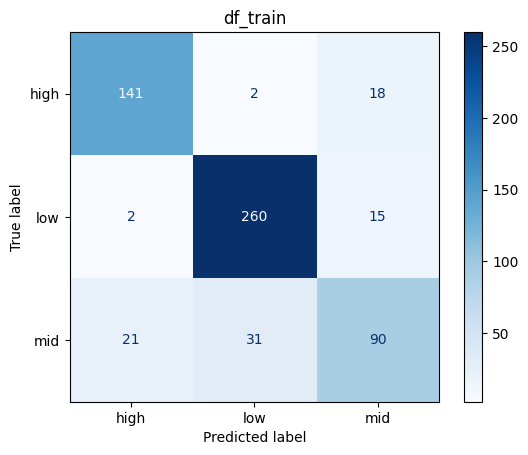

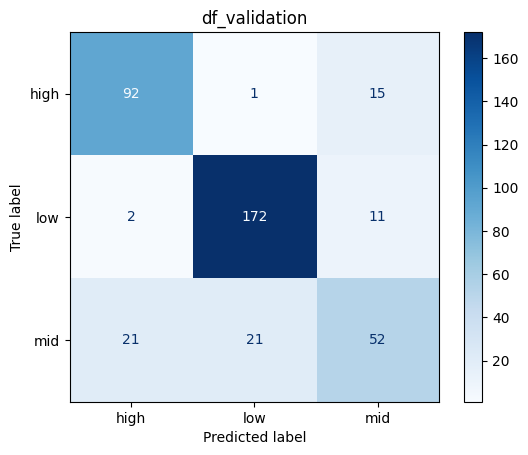

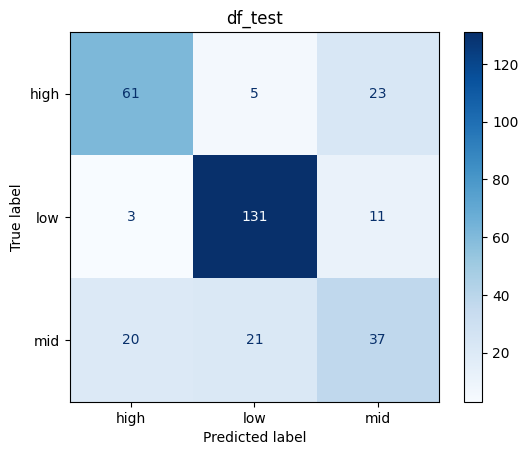

In [198]:
ln_clf = LogisticRegression(random_state=42)
ln_params = {
  'penalty': ['l1','l2','elasticnet'],
  'C': [0.001,0.01,0.1,1],
  'solver':['sag','saga','lbfgs','newton-cg'],
  'max_iter': [100,200,300],
  'multi_class': ['auto','ovr','multinominal']
}

clf = GridSearchCV(ln_clf, ln_params, refit=True, verbose=1)

ln_pipe = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

ln_pipe.fit(df_train, df_train.price_range)

clf.best_score_, clf.best_params_

evaluate_model(ln_pipe, title='', set_names=('df_train', 'df_validation', 'df_test'), show_cm=True)

### Decision Trees

**Hyper parametros**

Para utilizar  Arboles de decision, decidimos optar por agregar los siguientes parametros al Classifier
* **max_depth**: Indica la profundidad maxima del árbol
* **masx_features**: Indica el numero de valores a considerar cuando se busca por que lado expandir?

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,Accuracy,Precision,Recall,F1
df_train,0.944828,0.944547,0.932024,0.934772
df_validation,0.754522,0.715296,0.722804,0.716304
df_test,0.727564,0.680814,0.676684,0.676613


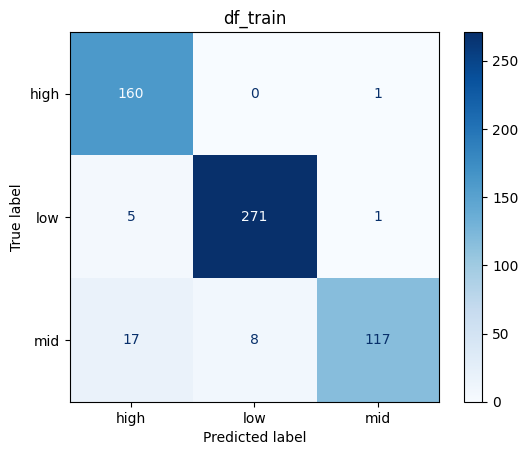

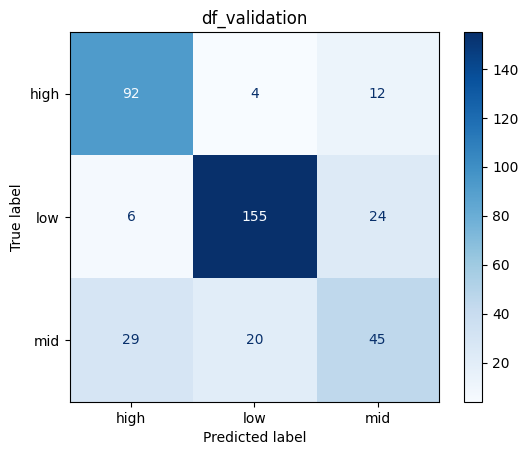

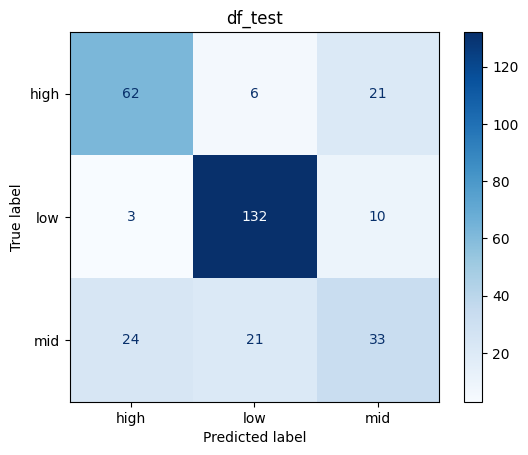

In [197]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_params = {
  'max_depth': [1, 2, 5, 10, 20, 25],
  'max_features': [2, 5, 7, 12, 19, 31, 50, None]
}

clf = GridSearchCV(dt_clf, dt_params, refit=True, verbose=1)

dt_pipe = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

dt_pipe.fit(df_train, df_train.price_range)

clf.best_score_, clf.best_params_

evaluate_model(dt_pipe, title='', set_names=('df_train', 'df_validation', 'df_test'), show_cm=True)

Se aprecia como en entrenamiento el modelo funciona muy bien, dando un resultado de  **0.94 de Accuracy**.

Por otro lado, el rendimiento recae en el test y validation

### Random Forest